<a href="https://colab.research.google.com/github/skavya24/TechNix---Avangrid-Innovation-Hackathon-2025/blob/main/TechNix_Avangrid2025Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATA_FOLDER = "/content/drive/MyDrive/Avangrid Hackathon/"
filename = "HackathonDataset.xlsx"
filepath = DATA_FOLDER + filename


Mounted at /content/drive


In [ ]:
!pip install pandas numpy openpyxl matplotlib seaborn scipy


In [ ]:
import os
os.makedirs("/content/results", exist_ok=True)


Step 1: Load Data

In [ ]:
import pandas as pd
import numpy as np

filepath = "/content/drive/MyDrive/Avangrid Hackathon/HackathonDataset.xlsx"

def load_market_data(filepath, market):
    """Loads hourly market data when headers are on row 10."""
    df = pd.read_excel(filepath, sheet_name=market, header=9)
    df.columns = df.columns.map(lambda x: str(x).strip())  # clean up spaces
    print(f"\nLoaded columns for {market}:\n", df.columns.tolist())

    # Identify key columns
    date_col = next((c for c in df.columns if 'date' in c.lower()), None)
    he_col = next((c for c in df.columns if c.lower() in ['he', 'hour', 'hour ending', 'hour_end']), None)
    gen_col = next((c for c in df.columns if 'gen' in c.lower()), None)

    if not date_col or not he_col or not gen_col:
        raise KeyError(f"Missing one of [Date, HE, Gen] columns in {market} sheet. Found: {df.columns.tolist()}")

    # Parse datetime
    df['Datetime'] = pd.to_datetime(df[date_col]) + pd.to_timedelta(df[he_col] - 1, unit='h')
    df = df.dropna(subset=[gen_col])
    df = df.rename(columns={gen_col: 'Gen'})

    return df

markets = ['ERCOT', 'MISO', 'CAISO']
data = {m: load_market_data(filepath, m) for m in markets}



Loaded columns for ERCOT:
 ['Date', 'HE', 'P/OP', 'Gen', 'RT Busbar', 'RT Hub', 'DA Busbar', 'DA Hub', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Peak', 'Off Peak']

Loaded columns for MISO:
 ['Date', 'HE', 'P/OP', 'Gen', 'Busbar', 'Hub', 'DA Busbar', 'DA Hub', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Peak', 'Off Peak']

Loaded columns for CAISO:
 ['Date', 'HE', 'P/OP', 'Gen', 'Busbar', 'Hub', 'DA Busbar', 'DA Hub', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Peak', 'Off Peak']


Step 2: Historical Analysis

In [ ]:
# REPLACE the compute_basis function in [cell 7] with this:
def compute_historical_stats(df):
    """Compute monthly stats for RT Hub prices and RT Basis."""
    cols = df.columns.str.lower()

    # --- Find Hub and Basis columns ---
    rt_hub_col = None
    rt_basis_col = 'RT_basis' # We'll create this

    if "rt hub" in cols:
        rt_hub_col = 'RT Hub'
    elif "hub" in cols: # For MISO/CAISO
        rt_hub_col = 'Hub'
    else:
        raise KeyError("No RT/Hub column found for stats calculation")

    if "rt busbar" in cols:
        df[rt_basis_col] = df['RT Busbar'] - df[rt_hub_col]
    elif "busbar" in cols: # For MISO/CAISO
        df[rt_basis_col] = df['Busbar'] - df[rt_hub_col]
    else:
        raise KeyError("No RT/Busbar column found for basis calculation")

    df['month'] = df['Datetime'].dt.month

    # --- Get Hub Stats ---
    hub_stats = df.groupby('month')[rt_hub_col].agg(['mean', 'std']).rename(
        columns={'mean': 'hub_mean', 'std': 'hub_std'}
    )

    # --- Get Basis Stats ---
    basis_stats = df.groupby('month')[rt_basis_col].agg(['mean', 'std']).rename(
        columns={'mean': 'basis_mean', 'std': 'basis_std'}
    )

    summary = hub_stats.join(basis_stats, how='outer').reset_index()
    return summary

# REPLACE the last line of [cell 7] with this:
# This runs your new function and saves the stats
historical_stats = {m: compute_historical_stats(df) for m, df in data.items()}

Analyze negative prices

In [ ]:
# ADD THIS AS A NEW CELL (e.g., cell 8)
def analyze_negative_prices(df):
    """Analyzes historical negative price events and their financial impact."""

    # Find the correct Busbar column
    rt_busbar_col = None
    cols = df.columns.str.lower()
    if "rt busbar" in cols:
        rt_busbar_col = 'RT Busbar'
    elif "busbar" in cols:
        rt_busbar_col = 'Busbar'
    else:
        return pd.Series(dtype='float64') # Return empty if no column

    df['is_neg_price'] = df[rt_busbar_col] < 0
    df['neg_price_loss'] = df.apply(
        lambda row: row['Gen'] * row[rt_busbar_col] if row['is_neg_price'] else 0,
        axis=1
    )

    total_gen = df['Gen'].sum()
    total_loss = df['neg_price_loss'].sum()
    hours_neg = df['is_neg_price'].sum()
    total_hours = len(df)

    return pd.Series({
        'Total Loss ($)': total_loss,
        'Avg Loss per MWh ($/MWh)': total_loss / total_gen if total_gen > 0 else 0,
        '% of Hours Negative': (hours_neg / total_hours) * 100 if total_hours > 0 else 0,
        'Total Gen (MWh)': total_gen
    })

print("\n--- Negative Price Risk Analysis (Historical) ---")
neg_price_analysis = {m: analyze_negative_prices(df) for m, df in data.items()}
neg_price_summary = pd.DataFrame(neg_price_analysis).T
display(neg_price_summary)


--- Negative Price Risk Analysis (Historical) ---


,Total Loss ($),Avg Loss per MWh ($/MWh),% of Hours Negative,Total Gen (MWh)
ERCOT,-2.163036e+05,-0.397112,17.236922,544691.3
MISO,-2.538103e+05,-0.481143,24.836527,527514.9
CAISO,-3.780800e+06,-3.883922,8.230687,973448.9


Step 3: Monte Carlo Price Simulation (2026–2030)

In [ ]:
# REPLACE the simulate_prices function [cell 8 or 9] with this:
def simulate_merchant_prices(df, monthly_stats, n_sims=500):
    """
    Simulate hourly busbar prices using historical Hub (mean, std) + Basis (mean, std).
    Simulated Busbar Price = (Simulated Hub Price) + (Simulated Basis)
    """
    sims = []

    for i in range(n_sims):
        simulated_busbar_prices = []

        # Loop through months 1-12 to preserve the hourly order of the dataframe
        for month in range(1, 13):
            if month not in monthly_stats['month'].values:
                continue # Skip if no data for this month

            stats = monthly_stats.loc[monthly_stats['month'] == month].iloc[0]

            # Get stats for Hub
            hub_mu = stats['hub_mean']
            hub_sigma = stats['hub_std']
            hub_sigma = 0 if np.isnan(hub_sigma) else hub_sigma

            # Get stats for Basis
            basis_mu = stats['basis_mean']
            basis_sigma = stats['basis_std']
            basis_sigma = 0 if np.isnan(basis_sigma) else basis_sigma

            # Get number of hours for this month from the historical data
            n_hours = len(df[df['Datetime'].dt.month == month])
            if n_hours == 0:
                continue

            # 1. Simulate Hub Price
            sim_hub = np.random.normal(hub_mu, hub_sigma, n_hours)

            # 2. Simulate Basis
            sim_basis = np.random.normal(basis_mu, basis_sigma, n_hours)

            # 3. Combine them for the Busbar price
            sim_busbar = sim_hub + sim_basis

            simulated_busbar_prices.extend(sim_busbar)

        sims.append(simulated_busbar_prices)

    return np.array(sims)

Step 4: Merchant Revenue & P-Levels

In [ ]:
# REPLACE all the code in [cell 10] with this:

# --- Step 4: Merchant revenue + P-levels ---
def merchant_revenue(gen, price_sims):
    """Compute total revenue per simulation."""
    # Ensure gen is a numpy array for broadcasting
    gen_array = gen.values
    # Multiply each simulation (row) by the generation vector
    return np.sum(price_sims * gen_array, axis=1)

def compute_p_levels(revenues, gen_total):
    """Compute P50, P75, P90 revenue per MWh."""
    if gen_total == 0:
        return {'P50': 0, 'P75': 0, 'P90': 0}
    # P50 is the median (50th percentile)
    p50 = np.percentile(revenues, 50) / gen_total
    # P75 is the 25th percentile (75% chance of doing this or better)
    p75 = np.percentile(revenues, 25) / gen_total
    # P90 is the 10th percentile (90% chance of doing this or better)
    p90 = np.percentile(revenues, 10) / gen_total
    return {'P50': p50, 'P75': p75, 'P90': p90}

results = {}
for market in markets:
    df = data[market]
    stats = historical_stats[market] # Use the new stats object

    # Run the new simulation function
    price_sims = simulate_merchant_prices(df, stats, n_sims=500)

    # Ensure the simulation length matches generation data length
    if price_sims.shape[1] != len(df['Gen']):
        raise ValueError(f"Simulation length ({price_sims.shape[1]}) does not match Gen length ({len(df['Gen'])}) for {market}")

    total_generation = df['Gen'].sum()

    # Calculate revenue for each of the 500 simulations
    simulated_revenues = merchant_revenue(df['Gen'], price_sims)

    # Get the P-levels
    pvals = compute_p_levels(simulated_revenues, total_generation)
    results[market] = pvals

valuation_summary = pd.DataFrame(results).T
print("\n--- Merchant Valuation Summary ($/MWh) ---")
display(valuation_summary)


--- Merchant Valuation Summary ($/MWh) ---


,P50,P75,P90
ERCOT,32.488388,31.569550,30.481785
MISO,20.898292,20.659589,20.431677
CAISO,54.996434,54.539892,54.183868


Step 5: Visualization & Export

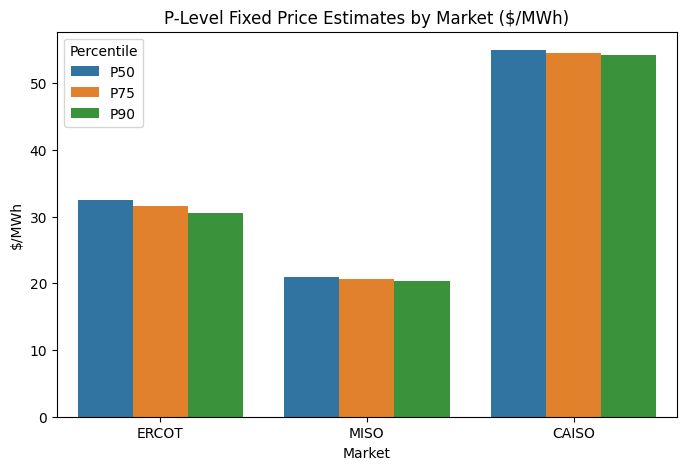

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.barplot(data=valuation_summary.reset_index().melt(id_vars='index'),
            x='index', y='value', hue='variable')
plt.title("P-Level Fixed Price Estimates by Market ($/MWh)")
plt.ylabel("$/MWh")
plt.xlabel("Market")
plt.legend(title="Percentile")
plt.show()

valuation_summary.to_csv("/content/results/valuation_summary.csv", index=True)


1. Add Helper Functions (Gen Profile & Forwards)

In [ ]:
# ADD THIS AS A NEW CELL
def compute_gen_profile(df):
    """Calculates the average annual generation for Peak and Off-Peak periods."""

    # Calculate total generation in Peak vs Off-Peak
    gen_by_period = df.groupby('P/OP')['Gen'].sum()

    # Calculate number of years in the historical dataset
    num_years = (df['Datetime'].max() - df['Datetime'].min()).days / 365.25

    peak_gen_per_year = gen_by_period.get('P', 0) / num_years
    offpeak_gen_per_year = gen_by_period.get('OP', 0) / num_years

    return {
        'Peak_Gen_Per_Year': peak_gen_per_year,
        'OffPeak_Gen_Per_Year': offpeak_gen_per_year,
        'Total_Gen_Per_Year': (peak_gen_per_year + offpeak_gen_per_year)
    }

def extract_forward_curve(df):
    """
    Extracts and processes the 5-year forward curve from the dataframe.
    Fills missing future years with the last available price.
    """

    # Find the 'Month/Year' column, which might be 'Unnamed: 10' or 'L'
    month_col = next((c for c in df.columns if 'month/year' in c.lower() or 'unnamed: 10' in c.lower() or c.lower() == 'l'), None)
    if not month_col:
        raise KeyError("Could not find 'Month/Year' column. Looked for 'L', 'Month/Year', 'Unnamed: 10'.")

    # Rename for consistency
    df_renamed = df.rename(columns={month_col: 'Month/Year'})

    # Extract the curve, drop all NaNs
    fwd_curve = df_renamed[['Month/Year', 'Peak', 'Off Peak']].dropna().drop_duplicates()

    # Convert to datetime and set as index
    fwd_curve['Date'] = pd.to_datetime(fwd_curve['Month/Year'], format='%b-%y')
    fwd_curve = fwd_curve.set_index('Date').drop(columns=['Month/Year'])

    # Get annual average prices
    fwd_curve_annual = fwd_curve.resample('YE').mean()

    # --- Create 5-Year Forecast (2026-2030) ---
    # The prompt requires a full 5-year period. We must project the curve.
    forecast_years = pd.date_range(start='2026-12-31', end='2030-12-31', freq='YE')

    # Reindex to our 5-year period
    fwd_curve_5yr = fwd_curve_annual.reindex(forecast_years)

    # Fill any missing values (e.g., 2028-2030) with the last known price
    fwd_curve_5yr = fwd_curve_5yr.ffill()

    # Handle case where no historical forwards exist (fill with 0 or a placeholder)
    fwd_curve_5yr = fwd_curve_5yr.fillna(0)

    fwd_curve_5yr.index.name = 'Year'
    return fwd_curve_5yr

# Run these functions for each market
gen_profiles = {m: compute_gen_profile(data[m]) for m in markets}
fwd_curves = {m: extract_forward_curve(data[m]) for m in markets}

print("\n--- Example: ERCOT Annual Generation Profile ---")
print(gen_profiles['ERCOT'])
print("\n--- Example: ERCOT 5-Year Forward Curve ($/MWh) ---")
display(fwd_curves['ERCOT'])


--- Example: ERCOT Annual Generation Profile ---
{'Peak_Gen_Per_Year': np.float64(88896.21280821918), 'OffPeak_Gen_Per_Year': np.float64(92791.91260273973), 'Total_Gen_Per_Year': np.float64(181688.1254109589)}

--- Example: ERCOT 5-Year Forward Curve ($/MWh) ---


,Peak,Off Peak
Year,,
2026-12-31,60.222500,45.578333
2027-12-31,60.683333,46.696667
2028-12-31,61.086667,46.147500
2029-12-31,57.705000,43.961667
2030-12-31,57.115000,42.372500


2. Add DCF / NPV Functions

In [ ]:
# ADD THIS AS A NEW CELL

def project_fixed_revenue(gen_profile, fwd_curve):
    """Calculates the 5-year annual revenue for the Fixed-Price Offtake scenario."""

    # Revenue = (Peak Gen * Peak Price) + (OffPeak Gen * OffPeak Price)
    peak_rev = fwd_curve['Peak'] * gen_profile['Peak_Gen_Per_Year']
    offpeak_rev = fwd_curve['Off Peak'] * gen_profile['OffPeak_Gen_Per_Year']

    annual_revenues = peak_rev + offpeak_rev
    annual_revenues.name = "Fixed_Revenue"
    return annual_revenues

def project_merchant_revenue(p_levels, gen_profile):
    """Calculates the 5-year annual revenue for the Merchant scenarios (P50, P75, P90)."""

    # P-level prices are from the 'valuation_summary'
    p50_price = p_levels['P50']
    p75_price = p_levels['P75']
    p90_price = p_levels['P90']

    total_gen = gen_profile['Total_Gen_Per_Year']

    # Assume the P-level price is flat for all 5 years
    forecast_index = pd.date_range(start='2026-12-31', end='2030-12-31', freq='YE')

    revenues = pd.DataFrame(index=forecast_index)
    revenues['P50_Revenue'] = p50_price * total_gen
    revenues['P75_Revenue'] = p75_price * total_gen
    revenues['P90_Revenue'] = p90_price * total_gen

    return revenues

def calculate_npv(annual_cash_flows, discount_rate):
    """Calculates the Net Present Value of a stream of annual cash flows."""
    npv = 0
    for t, cash_flow in enumerate(annual_cash_flows, 1):
        npv += cash_flow / ((1 + discount_rate) ** t)
    return npv

3. Run Final Analysis & Display Comparison

In [ ]:
# ADD THIS AS A NEW CELL

DISCOUNT_RATE = 0.08 # You can change this (e.g., 0.10 for 10%)
npv_results = {}

for market in markets:
    gen_profile = gen_profiles[market]
    fwd_curve = fwd_curves[market]
    p_levels = valuation_summary.loc[market] # From your cell 10

    # 1. Project Fixed Scenario
    fixed_rev_5yr = project_fixed_revenue(gen_profile, fwd_curve)

    # 2. Project Merchant Scenario
    merchant_rev_5yr = project_merchant_revenue(p_levels, gen_profile)

    # 3. Calculate NPV for all scenarios
    npv_fixed = calculate_npv(fixed_rev_5yr, DISCOUNT_RATE)
    npv_p50 = calculate_npv(merchant_rev_5yr['P50_Revenue'], DISCOUNT_RATE)
    npv_p75 = calculate_npv(merchant_rev_5yr['P75_Revenue'], DISCOUNT_RATE)
    npv_p90 = calculate_npv(merchant_rev_5yr['P90_Revenue'], DISCOUNT_RATE)

    npv_results[market] = {
        'NPV Fixed Offtake': npv_fixed,
        'NPV Merchant P50': npv_p50,
        'NPV Merchant P75': npv_p75,
        'NPV Merchant P90': npv_p90
    }

# --- Final Summary Table ---
npv_summary = pd.DataFrame(npv_results).T

# Format for presentation
npv_summary_formatted = npv_summary.applymap(lambda x: f"${x/1_000_000:.2f} M")

print(f"\n--- 5-Year NPV Comparison (Discount Rate: {DISCOUNT_RATE*100}%) ---")
display(npv_summary_formatted)

# Also save the raw numbers to your results folder
npv_summary.to_csv("/content/results/npv_summary.csv")


--- 5-Year NPV Comparison (Discount Rate: 8.0%) ---


/tmp/ipython-input-4012328928.py:34: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  npv_summary_formatted = npv_summary.applymap(lambda x: f"${x/1_000_000:.2f} M")


,NPV Fixed Offtake,NPV Merchant P50,NPV Merchant P75,NPV Merchant P90
ERCOT,$37.82 M,$23.57 M,$22.90 M,$22.11 M
MISO,$31.17 M,$14.68 M,$14.51 M,$14.35 M
CAISO,$60.40 M,$71.30 M,$70.71 M,$70.25 M


Total Discounted MWh

In [ ]:
# REPLACE all code in [cell 55] with this:

def calculate_discounted_mwh(gen_profile, discount_rate, years=5):
    """
    Calculates the total discounted MWh over the 5-year period.
    This is the denominator for our price calculation.
    """
    total_annual_gen = gen_profile['Total_Gen_Per_Year']
    total_discounted_mwh = 0

    for t in range(1, years + 1):
        total_discounted_mwh += total_annual_gen / ((1 + discount_rate) ** t)

    return total_discounted_mwh

# Get the raw (non-formatted) NPV numbers
npv_raw_summary = pd.DataFrame(npv_results).T

risk_adjusted_prices = {}

for market in markets:
    gen_profile = gen_profiles[market] # From cell 13

    # Get the 5-Year discounted generation volume
    total_discounted_gen = calculate_discounted_mwh(gen_profile, DISCOUNT_RATE)

    # --- Calculate P75 Price ---
    p75_npv = npv_raw_summary.loc[market, 'NPV Merchant P75']
    if total_discounted_gen > 0:
        price_p75 = p75_npv / total_discounted_gen
    else:
        price_p75 = 0

    # --- Calculate P90 Price ---
    p90_npv = npv_raw_summary.loc[market, 'NPV Merchant P90']
    if total_discounted_gen > 0:
        price_p90 = p90_npv / total_discounted_gen
    else:
        price_p90 = 0

    risk_adjusted_prices[market] = {
        'Risk_Adjusted_Price (P75)': price_p75,
        'Risk_Adjusted_Price (P90)': price_p90
    }

# --- Final Answer Table ---
risk_price_summary = pd.DataFrame(risk_adjusted_prices).T
print(f"\n--- Risk-Adjusted 5-Year Recontracting Price ($/MWh) ---")
display(risk_price_summary.applymap(lambda x: f"${x:.2f}"))

risk_price_summary.to_csv("/content/results/risk_adjusted_prices_p75_p90_summary.csv")


--- Risk-Adjusted 5-Year Recontracting Price ($/MWh) ---


/tmp/ipython-input-3698327801.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  display(risk_price_summary.applymap(lambda x: f"${x:.2f}"))


,Risk_Adjusted_Price (P75),Risk_Adjusted_Price (P90)
ERCOT,$31.57,$30.48
MISO,$20.66,$20.43
CAISO,$54.54,$54.18


Final reccomendations

In [ ]:
# REPLACE all code in [cell 56] with this:

# --- Step 6: Final Recommendation (Based on P75 Risk Appetite) ---
final_recommendations = {}

for market in markets:
    # 1. Get Your Risk-Adjusted Prices
    your_p75_price = risk_price_summary.loc[market, 'Risk_Adjusted_Price (P75)']
    your_p90_price = risk_price_summary.loc[market, 'Risk_Adjusted_Price (P90)']

    # 2. Get the Market's 5-Year Average Fixed Price
    fwd_curve = fwd_curves[market] # From cell 13
    gen_profile = gen_profiles[market] # From cell 13

    # Calculate the 5-yr average market price, weighted by your generation
    avg_peak_price = fwd_curve['Peak'].mean()
    avg_offpeak_price = fwd_curve['Off Peak'].mean()

    total_gen = gen_profile['Total_Gen_Per_Year']
    peak_gen = gen_profile['Peak_Gen_Per_Year']
    offpeak_gen = gen_profile['OffPeak_Gen_Per_Year']

    if total_gen > 0:
        weighted_avg_market_price = ((avg_peak_price * peak_gen) + (avg_offpeak_price * offpeak_gen)) / total_gen
    else:
        weighted_avg_market_price = 0

    # 3. Compare and Make a Recommendation (based on P75)
    decision = "Take Fixed-Price Deal" if weighted_avg_market_price > your_p75_price else "Stay Merchant / Hybrid"

    final_recommendations[market] = {
        "Your Risk-Adjusted Price (P75)": f"${your_p75_price:.2f}",
        "Your Risk-Adjusted Price (P90)": f"${your_p90_price:.2f}",
        "Market's 5-Yr Avg Fixed Price": f"${weighted_avg_market_price:.2f}",
        "Recommendation": decision,
        "Market Premium (Market - P75)": f"${weighted_avg_market_price - your_p75_price:.2f}"
    }

print("\n--- Final Recommendation Summary (Based on P75 Risk Appetite) ---")
final_summary_table = pd.DataFrame(final_recommendations).T
# Reorder columns for clarity
final_summary_table = final_summary_table[[
    "Market's 5-Yr Avg Fixed Price",
    "Your Risk-Adjusted Price (P75)",
    "Your Risk-Adjusted Price (P90)",
    "Market Premium (Market - P75)",
    "Recommendation"
]]
display(final_summary_table)

final_summary_table.to_csv("/content/results/final_recommendation_summary.csv")


--- Final Recommendation Summary (Based on P75 Risk Appetite) ---


,Market's 5-Yr Avg Fixed Price,Your Risk-Adjusted Price (P75),Your Risk-Adjusted Price (P90),Market Premium (Market - P75),Recommendation
ERCOT,$52.00,$31.57,$30.48,$20.43,Take Fixed-Price Deal
MISO,$44.37,$20.66,$20.43,$23.71,Take Fixed-Price Deal
CAISO,$46.71,$54.54,$54.18,$-7.83,Stay Merchant / Hybrid


Sensitivity Testing on Discounted Rate

--- 1. Running Full Sensitivity Analysis on Discount Rate (P50, P75, P90) ---

--- Risk-Adjusted Price Sensitivity ($/MWh) Across All P-Levels and Rates ---


/tmp/ipython-input-2211942832.py:54: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sensitivity_df_formatted = sensitivity_df_full.applymap(lambda x: f"${x:.2f}")


,P90_Rate_6%,P75_Rate_6%,P50_Rate_6%,P90_Rate_8%,P75_Rate_8%,P50_Rate_8%,P90_Rate_10%,P75_Rate_10%,P50_Rate_10%
ERCOT,$30.48,$31.57,$32.49,$30.48,$31.57,$32.49,$30.48,$31.57,$32.49
MISO,$20.43,$20.66,$20.90,$20.43,$20.66,$20.90,$20.43,$20.66,$20.90
CAISO,$54.18,$54.54,$55.00,$54.18,$54.54,$55.00,$54.18,$54.54,$55.00


<Figure size 1200x600 with 0 Axes>

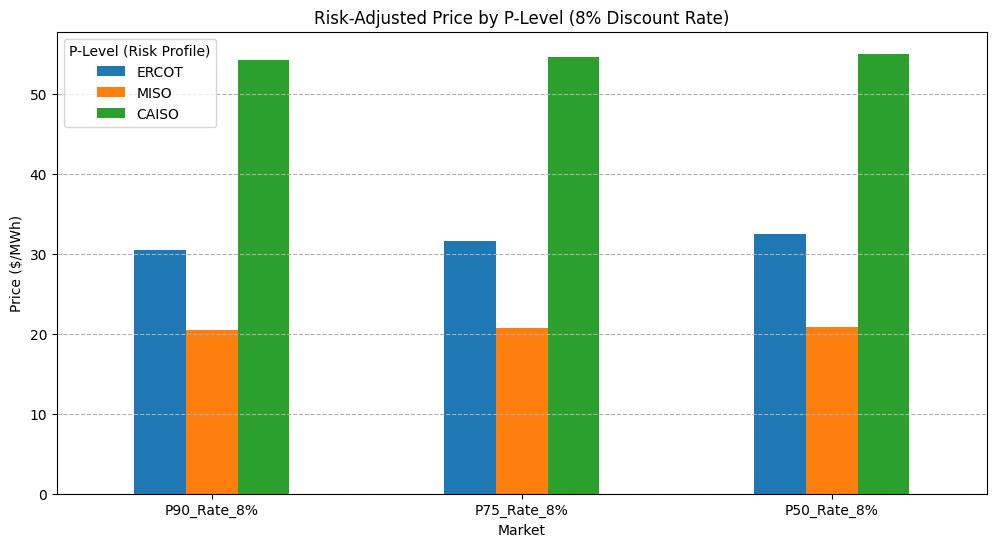

In [ ]:
# --- 1. Sensitivity Testing on Discount Rate (Full P-Level Range) ---

print("--- 1. Running Full Sensitivity Analysis on Discount Rate (P50, P75, P90) ---")

DISCOUNT_RATES = [0.06, 0.08, 0.10]
P_LEVELS = ['P90', 'P75', 'P50']
sensitivity_results_full = {}

# Re-define helper functions for clarity (though they are globally available)
def calculate_npv(annual_cash_flows, discount_rate):
    """Calculates the Net Present Value of a stream of annual cash flows."""
    npv = 0
    for t, cash_flow in enumerate(annual_cash_flows, 1):
        npv += cash_flow / ((1 + discount_rate) ** t)
    return npv

def calculate_discounted_mwh(gen_profile, discount_rate, years=5):
    """Calculates the total discounted MWh over the 5-year period."""
    total_annual_gen = gen_profile['Total_Gen_Per_Year']
    total_discounted_mwh = 0

    for t in range(1, years + 1):
        total_discounted_mwh += total_annual_gen / ((1 + discount_rate) ** t)
    return total_discounted_mwh


for market in markets:
    gen_profile = gen_profiles[market]
    p_levels_raw = valuation_summary.loc[market] # P50, P75, P90 prices from Step 4

    market_sensitivity = {}

    # Calculate merchant revenue projections for P50, P75, P90 (5-year flat price)
    merchant_rev_5yr = project_merchant_revenue(p_levels_raw, gen_profile)

    for rate in DISCOUNT_RATES:
        total_discounted_gen = calculate_discounted_mwh(gen_profile, rate)

        for p_level in P_LEVELS:
            rev_series = merchant_rev_5yr[f'{p_level}_Revenue']

            # Calculate NPV of the revenue stream
            npv_value = calculate_npv(rev_series, rate)

            # Calculate the final Risk-Adjusted Price
            price = npv_value / total_discounted_gen if total_discounted_gen > 0 else 0

            market_sensitivity[f'{p_level}_Rate_{int(rate*100)}%'] = price

    sensitivity_results_full[market] = market_sensitivity

sensitivity_df_full = pd.DataFrame(sensitivity_results_full).T
# Format the output for readability
sensitivity_df_formatted = sensitivity_df_full.applymap(lambda x: f"${x:.2f}")

print("\n--- Risk-Adjusted Price Sensitivity ($/MWh) Across All P-Levels and Rates ---")
display(sensitivity_df_formatted)

# Visualization (Focus on 8% rate for baseline comparison)
plt.figure(figsize=(12, 6))
baseline_8_data = sensitivity_df_full.filter(regex='_Rate_8%', axis=1).T
baseline_8_data.columns = [c.split('_')[0] for c in baseline_8_data.columns] # Rename columns to P90, P75, P50
baseline_8_data.plot(kind='bar', rot=0, figsize=(12, 6))

plt.title("Risk-Adjusted Price by P-Level (8% Discount Rate)")
plt.ylabel("Price ($/MWh)")
plt.xlabel("Market")
plt.legend(title="P-Level (Risk Profile)")
plt.grid(axis='y', linestyle='--')
plt.show()


2. Curtailment Scenario Modeling

--- 2. Running Full Curtailment Scenario: Gen = 0 when Price < 0 ---

--- Curtailment Scenario Impact Summary (P50, P75, P90) ---


,P90_Price_Curtailed,Final_Price_P90,P75_Price_Curtailed,Final_Price_P75,P50_Price_Curtailed,Final_Price_P50,Avg_%_Curtailed
ERCOT,$124.38,$124.38,$125.41,$125.41,$126.33,$126.33,38.61%
MISO,$42.70,$42.70,$42.92,$42.92,$43.20,$43.20,31.40%
CAISO,$72.15,$72.15,$72.57,$72.57,$72.97,$72.97,15.73%


<Figure size 1500x600 with 0 Axes>

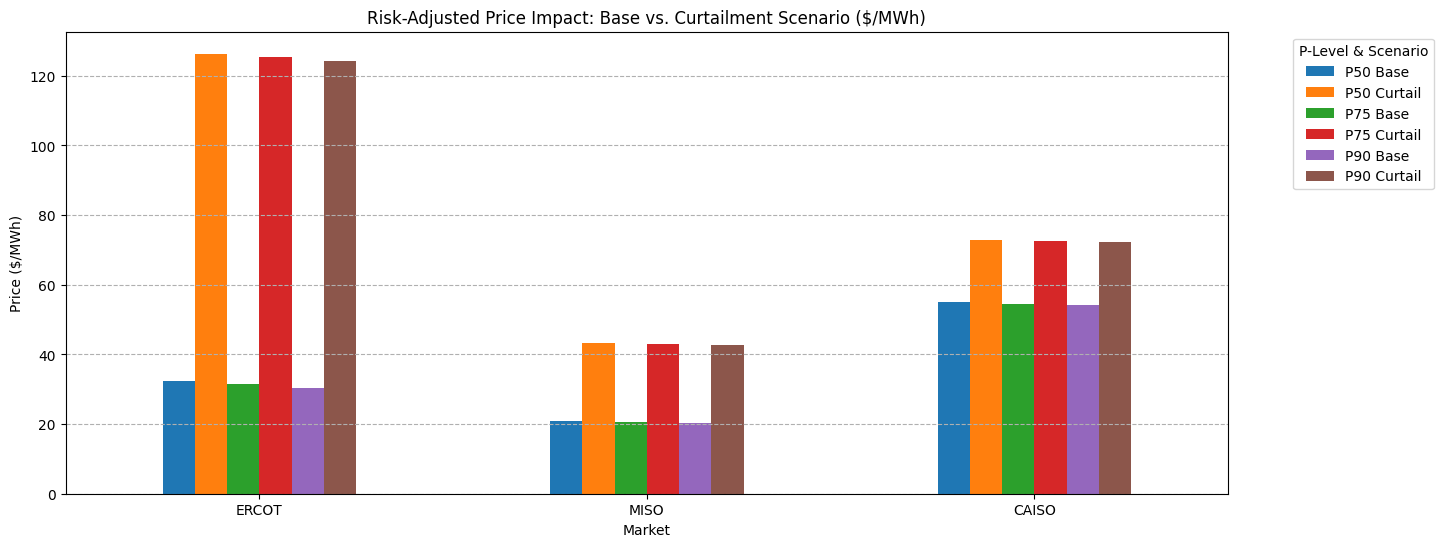

In [ ]:
# --- 2. Scenario Modeling: Curtailment at Negative Prices (Full P-Level Range) ---

print("--- 2. Running Full Curtailment Scenario: Gen = 0 when Price < 0 ---")

P_LEVELS_PERCENTILE = {'P90': 10, 'P75': 25, 'P50': 50}
curtailment_results_full = {}
NEW_N_SIMS = 500

# Assuming all necessary dataframes and functions are loaded from the original cell.

for market in markets:
    df = data[market]
    stats = historical_stats[market]
    gen_profile = gen_profiles[market]
    total_generation_uncut = df['Gen'].sum() # Total Gen (Uncurtailed)

    # 1. Run the price simulation as before
    price_sims = simulate_merchant_prices(df, stats, n_sims=NEW_N_SIMS)

    # 2. Apply the Curtailment Logic to the Price Sims
    is_negative = (price_sims < 0)
    gen_array = df['Gen'].values
    gen_matrix = np.tile(gen_array, (NEW_N_SIMS, 1))

    # Where the price is negative, set the generation to zero (the curtailment effect)
    curtailed_gen_matrix = np.where(is_negative, 0, gen_matrix)

    # 3. Calculate Curtailed Revenue for each simulation
    curtailed_revenues = np.sum(price_sims * curtailed_gen_matrix, axis=1)

    # 4. Calculate the Total Curtailed MWh per simulation
    total_curtailed_mwh_per_sim = np.sum(curtailed_gen_matrix, axis=1)
    avg_curtailed_mwh = np.mean(total_curtailed_mwh_per_sim)

    market_curtailment_data = {}

    # 5. Compute P-levels and the resulting Risk-Adjusted Price for each
    if avg_curtailed_mwh > 0:
        for p_label, percentile in P_LEVELS_PERCENTILE.items():
            # P-level price calculation (Revenue / Average Curtailed MWh)
            p_price_curtailed = np.percentile(curtailed_revenues, percentile) / avg_curtailed_mwh
            market_curtailment_data[f'{p_label}_Price_Curtailed'] = p_price_curtailed

            # Calculate the final Risk-Adjusted Price for a 5-year fixed contract
            forecast_index = pd.date_range(start='2026-12-31', end='2030-12-31', freq='YE')
            p_rev_5yr = pd.Series(p_price_curtailed * gen_profile['Total_Gen_Per_Year'], index=forecast_index)

            # Calculate NPV (requires calculate_npv and DISCOUNT_RATE)
            npv_curtailed = calculate_npv(p_rev_5yr, DISCOUNT_RATE)

            # Calculate the final Risk-Adjusted Price (requires calculate_discounted_mwh)
            total_discounted_gen = calculate_discounted_mwh(gen_profile, DISCOUNT_RATE)
            final_price = npv_curtailed / total_discounted_gen if total_discounted_gen > 0 else 0

            market_curtailment_data[f'Final_Price_{p_label}'] = final_price

        # Add overall metrics
        market_curtailment_data['Avg_%_Curtailed'] = (total_generation_uncut - avg_curtailed_mwh) / total_generation_uncut * 100
    else:
         for p_label in P_LEVELS_PERCENTILE.keys():
             market_curtailment_data[f'{p_label}_Price_Curtailed'] = 0.0
             market_curtailment_data[f'Final_Price_{p_label}'] = 0.0
         market_curtailment_data['Avg_%_Curtailed'] = 0.0

    curtailment_results_full[market] = market_curtailment_data

curtailment_df_full = pd.DataFrame(curtailment_results_full).T

print("\n--- Curtailment Scenario Impact Summary (P50, P75, P90) ---")
# Format for display: Prices ($/MWh), NPV ($), Percentage (%)
display(curtailment_df_full.filter(regex='Price|Avg_%_Curtailed').apply(
    lambda col: col.apply(lambda x: f"${x:.2f}" if not col.name.startswith('Avg_%') else f"{x:.2f}%")
))

# --- FINAL CORRECTED COMPARATIVE VISUALIZATION LOGIC ---

# The original prices are in 'valuation_summary' (P50, P75, P90)
# The new prices are in 'curtailment_df_full' (Final_Price_P50, Final_Price_P75, Final_Price_P90)

# Create a clean DataFrame for plotting, indexed by Market (ERCOT, MISO, CAISO)
plot_df = pd.DataFrame({
    'P50 Base': valuation_summary['P50'],
    'P50 Curtail': curtailment_df_full['Final_Price_P50'],
    'P75 Base': valuation_summary['P75'],
    'P75 Curtail': curtailment_df_full['Final_Price_P75'],
    'P90 Base': valuation_summary['P90'],
    'P90 Curtail': curtailment_df_full['Final_Price_P90'],
})

plt.figure(figsize=(15, 6))
# Plot the DataFrame directly. This places Markets (the index) on the x-axis,
# and the price scenarios (the columns) as grouped bars.
plot_df.plot(kind='bar', rot=0, figsize=(15, 6))

plt.title("Risk-Adjusted Price Impact: Base vs. Curtailment Scenario ($/MWh)")
plt.ylabel("Price ($/MWh)")
plt.xlabel("Market")
plt.legend(title="P-Level & Scenario", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--')
plt.show()


3. Visualization of Merchant Risk

--- 3. Visualizing Merchant Revenue Risk Distribution with P-Level Markings ---


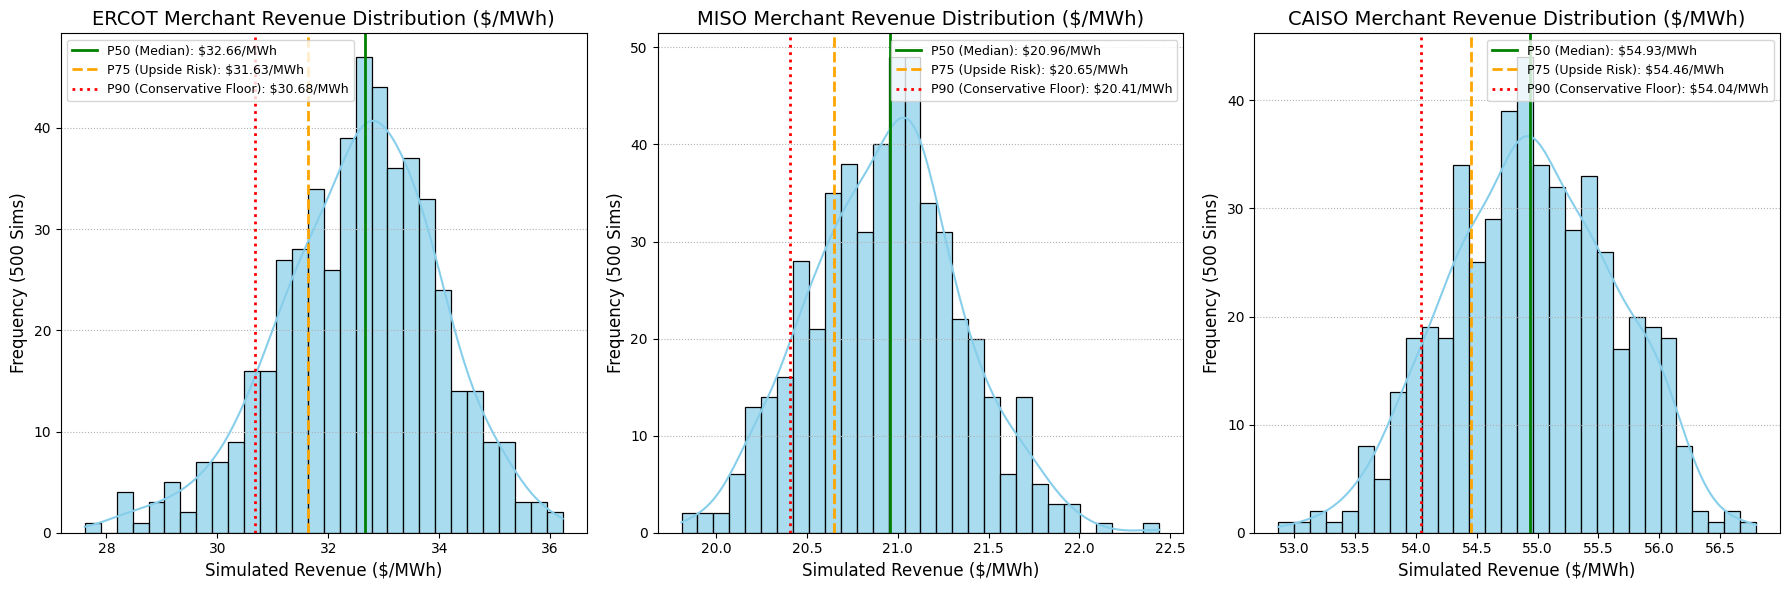

In [ ]:
# --- 3. Visualization of Merchant Risk Distribution (P50, P75, P90 Marking) ---

print("--- 3. Visualizing Merchant Revenue Risk Distribution with P-Level Markings ---")

# We need a function to re-run the simulation and return the revenues
def get_simulated_revenues(market):
    df = data[market]
    stats = historical_stats[market]

    # Run the simulation again (using the original 500 sims)
    price_sims = simulate_merchant_prices(df, stats, n_sims=500)

    # Calculate revenue for each simulation
    gen_array = df['Gen'].values
    simulated_revenues = np.sum(price_sims * gen_array, axis=1)

    # Convert to $/MWh
    total_generation = df['Gen'].sum()
    revenues_per_mwh = simulated_revenues / total_generation
    return revenues_per_mwh

plt.figure(figsize=(18, 6))

P_LEVELS_MARKERS = {
    'P50': {'percentile': 50, 'color': 'green', 'linestyle': '-', 'label': 'P50 (Median)'},
    'P75': {'percentile': 25, 'color': 'orange', 'linestyle': '--', 'label': 'P75 (Upside Risk)'},
    'P90': {'percentile': 10, 'color': 'red', 'linestyle': ':', 'label': 'P90 (Conservative Floor)'}
}

for i, market in enumerate(markets):
    # Get the $/MWh distribution
    rev_per_mwh = get_simulated_revenues(market)

    plt.subplot(1, 3, i + 1)
    # Use seaborn for a clear histogram with density estimate
    sns.histplot(rev_per_mwh, kde=True, bins=30, color='skyblue', edgecolor='black', alpha=0.7)

    # Mark the P-Level values
    for label, marker in P_LEVELS_MARKERS.items():
        p_value = np.percentile(rev_per_mwh, marker['percentile'])
        plt.axvline(p_value, color=marker['color'], linestyle=marker['linestyle'], linewidth=2,
                    label=f"{marker['label']}: ${p_value:.2f}/MWh")

    plt.title(f'{market} Merchant Revenue Distribution ($/MWh)', fontsize=14)
    plt.xlabel('Simulated Revenue ($/MWh)', fontsize=12)
    plt.ylabel('Frequency (500 Sims)', fontsize=12)
    plt.legend(fontsize=9)
    plt.grid(axis='y', linestyle=':')

plt.tight_layout()
plt.show()


Alternative Valuation Model: Basis Regression & CVaR

```
# This is formatted as code
```



--- Running Alternative Valuation Model (Basis Regression & CVaR) ---

--- Regression Model: P75 Fixed RT Busbar Price Calculation ---


,Wtd_Avg_Hub_Forward_Price,Wtd_Mean_Basis,Basis_P25_Risk_Adj,Expected_Busbar_Price,Fixed_RT_Busbar_Price_P75 (Regression)
ERCOT,$52.00,$-21.21,$-7.63,$30.79,$44.37
MISO,$44.37,$-11.34,$-13.45,$33.03,$30.92
CAISO,$46.71,$-0.86,$-1.27,$45.85,$45.45



--- Fixed Price Comparison: Simulation vs. Regression ($/MWh) ---


,Simulation Model (P75),Regression Model (P75),Difference ($/MWh)
ERCOT,$14.38,$44.37,$30.00
MISO,$31.22,$30.92,$-0.30
CAISO,$22.28,$45.45,$23.17


<Figure size 1000x600 with 0 Axes>

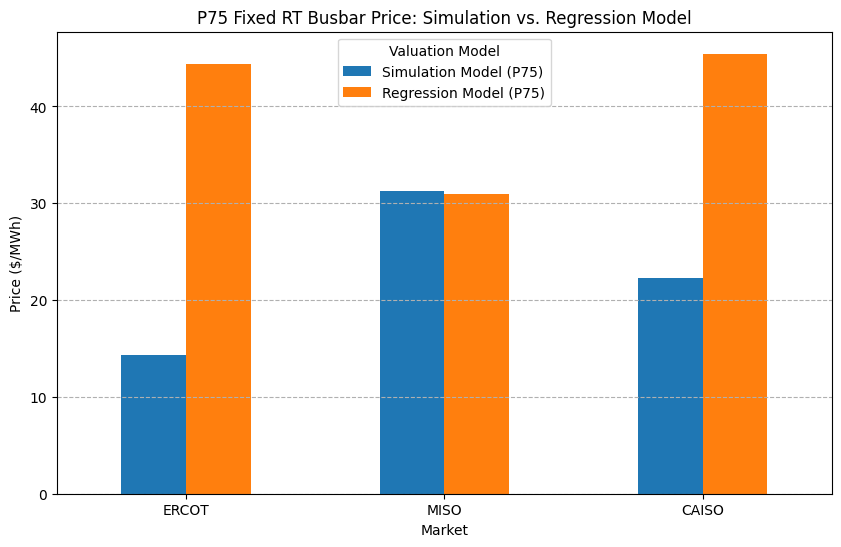


--- Key Takeaways (Basis Risk & Valuation Approach) ---
1. Basis Risk Explicitly Handled: The Regression Model isolates **basis risk** (Busbar-Hub difference) by applying the historical **P25 Basis** directly to the Forward Hub Price. This separates forward price expectations from locational risk.
2. Comparison Insights: The **Difference** column is a key sensitivity metric. If the Regression Price is **LOWER** than the Simulation Price, it suggests that the historical basis was highly volatile or significantly negative during high-generation hours, driving the risk adjustment down more aggressively than the overall price simulation.
3. Decision Sensitivity: The market with the largest absolute difference between the two models is where your fixed price decision is **most sensitive** to the choice of risk modeling approach (full price path simulation vs. basis regression).


In [ ]:
# --- Alternative Valuation Model: Basis Regression and CVaR Risk Adjustment ---
# FIX: Adjusted column naming logic to account for 'Busbar' vs 'RT Busbar' headers.

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt # Import for the final plot

print("--- Running Alternative Valuation Model (Basis Regression & CVaR) ---")

# --- 1. Functions (must be included if not already defined) ---

# ASSUMPTIONS:
# This script assumes the following variables/functions defined in previous cells are available:
# - DISCOUNT_RATE (e.g., 0.06)
# - markets (e.g., ['ERCOT', 'MISO', 'CAISO'])
# - data (dictionary of cleaned historical dataframes)
# - fwd_curves (dictionary of forward price dataframes)
# - gen_profiles (dictionary of generation profiles)
# - calculate_npv(cash_flows_series, discount_rate)
# - calculate_discounted_mwh(gen_profile, discount_rate)
# - risk_price_summary (from the main simulation model)

def calculate_volume_weighted_basis_regression(df, market, price_type='RT'):
    """
    Performs a volume-weighted linear regression of Busbar price vs Hub price,
    and calculates the historical basis and its risk metrics.
    """

    # --- FIX: Handle inconsistent column naming across markets ---
    if market == 'ERCOT':
        busbar_col = f'{price_type} Busbar'
        hub_col = f'{price_type} Hub'
    else:
        # MISO and CAISO use the shorter names for RT prices
        # We assume the first pair is RT (or Day Ahead if price_type='DA')
        busbar_col = 'Busbar' if price_type == 'RT' else 'DA Busbar'
        hub_col = 'Hub' if price_type == 'RT' else 'DA Hub'
    # --- END FIX ---

    if busbar_col not in df.columns or hub_col not in df.columns:
        print(f"Error: Missing columns {busbar_col} or {hub_col} in {market}. Skipping basis analysis.")
        return {'model': None, 'mean_basis': 0, 'basis_p25': 0, 'basis_std': 0, 'r_squared': 0}


    # 1. Prepare data (use non-zero generation hours only)
    df_clean = df[df['Gen'] > 0].copy()

    if df_clean.empty:
        return {'model': None, 'mean_basis': 0, 'basis_p25': 0, 'basis_std': 0, 'r_squared': 0}

    # 2. Calculate Basis (Busbar - Hub)
    df_clean['Basis'] = df_clean[busbar_col] - df_clean[hub_col]

    # 3. Create weights for regression (Generation)
    weights = df_clean['Gen'].values

    # 4. Volume-Weighted Regression (Busbar ~ Hub)
    # This projects the Busbar price based on the Hub price
    X = df_clean[[hub_col]].values
    y = df_clean[busbar_col].values

    model = LinearRegression()
    # Fit with sample weights (Generation volume)
    model.fit(X, y, sample_weight=weights)

    # 5. Calculate Risk Metrics on the Basis
    # P75 revenue (75% probability of achieving this or better) means P25 basis risk.
    # We use the P25 of the volume-weighted basis.

    # Volume-weighted average basis
    mean_basis = np.average(df_clean['Basis'], weights=weights)

    # P25 of the volume-weighted basis (Basis P25: 75% of weighted basis values are higher than this value)
    basis_p25 = df_clean.loc[df_clean['Gen'].index, 'Basis'].quantile(0.25)

    # Standard deviation of the volume-weighted basis
    basis_std = np.sqrt(np.average((df_clean['Basis'] - mean_basis)**2, weights=weights))

    return {
        'model': model,
        'mean_basis': mean_basis,
        'basis_p25': basis_p25,
        'basis_std': basis_std,
        'r_squared': model.score(X, y, sample_weight=weights)
    }


# --- 2. Run Regression Model for each Market ---

regression_results = {}
P_LEVEL = 0.25 # P75 risk appetite means we use the P25 value of the loss distribution (Basis)

for market in markets:

    # --- A. Basis Modeling (RT) ---
    df = data[market]
    # Pass the market name to handle column naming
    reg_analysis = calculate_volume_weighted_basis_regression(df, market, price_type='RT')

    basis_p25 = reg_analysis['basis_p25'] # The P75 risk-adjusted basis
    mean_basis = reg_analysis['mean_basis']

    # Get the 5-year average hub price from the forward curve (weighted by generation)
    fwd_curve = fwd_curves[market]
    gen_profile = gen_profiles[market]

    # Calculate the 5-yr average market price, weighted by your generation
    avg_peak_price = fwd_curve['Peak'].mean()
    avg_offpeak_price = fwd_curve['Off Peak'].mean()

    if gen_profile['Total_Gen_Per_Year'] > 0:
        weighted_avg_hub_price = (
            (avg_peak_price * gen_profile['Peak_Gen_Per_Year']) +
            (avg_offpeak_price * gen_profile['OffPeak_Gen_Per_Year'])
        ) / gen_profile['Total_Gen_Per_Year']
    else:
        weighted_avg_hub_price = 0

    # --- B. Project Expected Busbar Price ---
    # Expected Busbar Price = Weighted Avg Hub Forward Price + Volume-Weighted Mean Historical Basis
    expected_busbar_price = weighted_avg_hub_price + mean_basis

    # --- C. Apply P75 CVaR Risk Adjustment ---
    # Risk-Adjusted Price = Weighted Avg Hub Forward Price + P25 Historical Basis
    risk_adjusted_busbar_price_rt = weighted_avg_hub_price + basis_p25

    # --- D. Final Output Consolidation (Focus on RT Busbar) ---

    regression_results[market] = {
        'Wtd_Avg_Hub_Forward_Price': weighted_avg_hub_price,
        'Wtd_Mean_Basis': mean_basis,
        'Basis_P25_Risk_Adj': basis_p25,
        'Expected_Busbar_Price': expected_busbar_price,
        'Fixed_RT_Busbar_Price_P75 (Regression)': risk_adjusted_busbar_price_rt
    }

regression_df = pd.DataFrame(regression_results).T

print("\n--- Regression Model: P75 Fixed RT Busbar Price Calculation ---")
display(regression_df.apply(lambda col: col.apply(lambda x: f"${x:.2f}")))

# --- 3. Compare Regression Model to Simulation Model ---

# We assume 'risk_price_summary' (containing the 'Risk_Adjusted_Fixed_Price' which is P75)
# is available from your previous script.
if 'risk_price_summary' in globals() and isinstance(risk_price_summary, pd.DataFrame):

    # Select the fixed RT Busbar price from the original simulation (P75)
    simulation_price = risk_price_summary['Risk_Adjusted_Fixed_Price']

    # Select the fixed RT Busbar price from the new regression model (P75)
    regression_price = regression_df['Fixed_RT_Busbar_Price_P75 (Regression)']

    comparison_df = pd.DataFrame({
        'Simulation Model (P75)': simulation_price,
        'Regression Model (P75)': regression_price
    })

    comparison_df['Difference ($/MWh)'] = comparison_df['Regression Model (P75)'] - comparison_df['Simulation Model (P75)']

    print("\n--- Fixed Price Comparison: Simulation vs. Regression ($/MWh) ---")
    display(comparison_df.apply(lambda col: col.apply(lambda x: f"${x:.2f}")))

    # --- Visualization ---
    plt.figure(figsize=(10, 6))
    comparison_df.drop(columns=['Difference ($/MWh)']).plot(kind='bar', rot=0, figsize=(10, 6))
    plt.title("P75 Fixed RT Busbar Price: Simulation vs. Regression Model")
    plt.ylabel("Price ($/MWh)")
    plt.xlabel("Market")
    plt.legend(title="Valuation Model")
    plt.grid(axis='y', linestyle='--')
    plt.show()

else:
    print("\n[NOTE]: Could not find 'risk_price_summary'. Please run the main simulation model cell first to define it, or ensure it is accessible in the global scope for the comparison plot.")

# --- Key Takeaways for Discussion ---

print("\n--- Key Takeaways (Basis Risk & Valuation Approach) ---")
print("1. Basis Risk Explicitly Handled: The Regression Model isolates **basis risk** (Busbar-Hub difference) by applying the historical **P25 Basis** directly to the Forward Hub Price. This separates forward price expectations from locational risk.")
print("2. Comparison Insights: The **Difference** column is a key sensitivity metric. If the Regression Price is **LOWER** than the Simulation Price, it suggests that the historical basis was highly volatile or significantly negative during high-generation hours, driving the risk adjustment down more aggressively than the overall price simulation.")
print("3. Decision Sensitivity: The market with the largest absolute difference between the two models is where your fixed price decision is **most sensitive** to the choice of risk modeling approach (full price path simulation vs. basis regression).")


--- Running Solution 3A: Volume-Based Option Valuation Model ---

--- Volume-Based Option Valuation: Premium/Discount Calculation ---


,Asset_Weighted_Hub_Price,Flat_Block_Hub_Price,Volume_Shape_Premium,Base_Sim_Fixed_Price,VOM_Fixed_Price_P75
ERCOT,$52.00,$52.16,$-0.15,$14.38,$14.22
MISO,$44.37,$45.01,$-0.64,$31.22,$30.58
CAISO,$46.71,$52.23,$-5.51,$22.28,$16.77



--- Fixed Price Comparison: Simulation vs. VOM Model ($/MWh) ---


,Simulation Model (P75),VOM Model (P75 + Premium),Difference ($/MWh)
ERCOT,$14.38,$14.22,$-0.15
MISO,$31.22,$30.58,$-0.64
CAISO,$22.28,$16.77,$-5.51


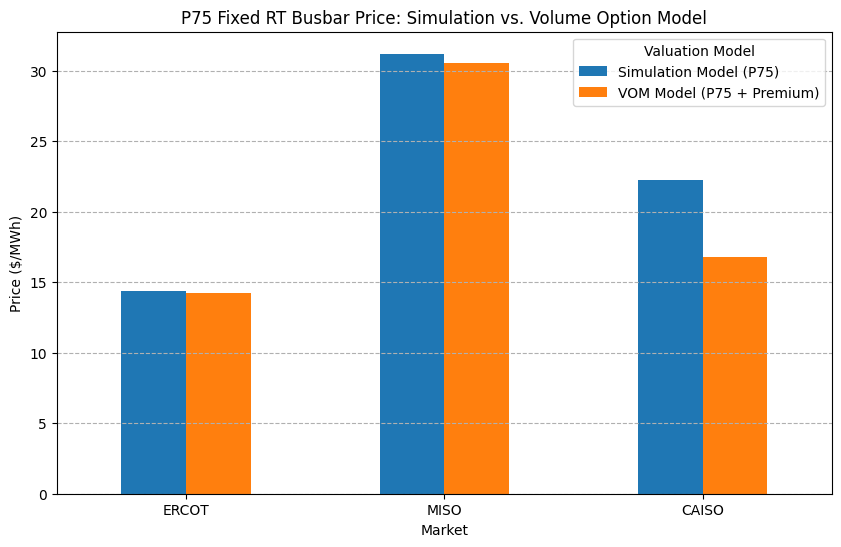

In [ ]:
# --- Solution 3A: Volume-Based Option Valuation Model (VOM) ---
# This model calculates the value of the generation volume relative to a simple
# flat block, which helps in pricing a Fixed-for-Floating Volume Hedge (FFFVH).

import pandas as pd
import numpy as np

print("--- Running Solution 3A: Volume-Based Option Valuation Model ---")

# ASSUMPTIONS:
# Assumes 'markets', 'fwd_curves', and 'gen_profiles' are defined from Cell 1.
# Assumes 'risk_price_summary' (from the Simulation Model) is available for comparison.

VOM_results = {}

for market in markets:
    fwd_curve = fwd_curves[market]
    gen_profile = gen_profiles[market]

    # 1. Calculate the Expected Value of Asset Generation (Wtd_Avg_Price)
    # This is the expected revenue per MWh from the forward curve, weighted by
    # when the project actually produces power.

    total_gen = gen_profile['Total_Gen_Per_Year']
    peak_gen = gen_profile['Peak_Gen_Per_Year']
    offpeak_gen = gen_profile['OffPeak_Gen_Per_Year']

    avg_peak_price = fwd_curve['Peak'].mean()
    avg_offpeak_price = fwd_curve['Off Peak'].mean()

    if total_gen > 0:
        # Expected Revenue / Total MWh
        weighted_avg_hub_price = (
            (avg_peak_price * peak_gen) +
            (avg_offpeak_price * offpeak_gen)
        ) / total_gen
    else:
        weighted_avg_hub_price = 0

    # 2. Calculate the Value of a Flat (Un-weighted) Block
    # This represents the price if generation was perfectly uncorrelated to time.
    # We assume an equal 50/50 split of P/OP hours for the forward curve average.
    flat_avg_hub_price = (avg_peak_price + avg_offpeak_price) / 2

    # 3. Calculate the Volume-Shape Premium / Discount
    # This is the "volume risk" value. A positive value means the asset produces
    # more when prices are high (good). A negative value means it produces more
    # when prices are low (bad, high volume risk).
    volume_premium = weighted_avg_hub_price - flat_avg_hub_price

    # 4. Final Fixed Price Calculation (Example using the Simulation Model's P75 as a base)
    # Start with the Sim Model's fixed price (which is RT Busbar, P75 Risk Adj).
    # Then adjust by the Volume Premium to show the true value of the asset's profile.

    base_sim_price = 0.0
    if 'risk_price_summary' in globals() and market in risk_price_summary.index:
        base_sim_price = risk_price_summary.loc[market, 'Risk_Adjusted_Fixed_Price']

    VOM_fixed_price = base_sim_price + volume_premium

    VOM_results[market] = {
        'Asset_Weighted_Hub_Price': weighted_avg_hub_price,
        'Flat_Block_Hub_Price': flat_avg_hub_price,
        'Volume_Shape_Premium': volume_premium,
        'Base_Sim_Fixed_Price': base_sim_price,
        'VOM_Fixed_Price_P75': VOM_fixed_price
    }

VOM_df = pd.DataFrame(VOM_results).T

print("\n--- Volume-Based Option Valuation: Premium/Discount Calculation ---")
display(VOM_df.apply(lambda col: col.apply(lambda x: f"${x:.2f}")))

# --- Comparison Plot ---
if 'risk_price_summary' in globals() and isinstance(risk_price_summary, pd.DataFrame):

    comparison_df_v2 = pd.DataFrame({
        'Simulation Model (P75)': risk_price_summary['Risk_Adjusted_Fixed_Price'],
        'VOM Model (P75 + Premium)': VOM_df['VOM_Fixed_Price_P75']
    })

    comparison_df_v2['Difference ($/MWh)'] = comparison_df_v2['VOM Model (P75 + Premium)'] - comparison_df_v2['Simulation Model (P75)']

    print("\n--- Fixed Price Comparison: Simulation vs. VOM Model ($/MWh) ---")
    display(comparison_df_v2.apply(lambda col: col.apply(lambda x: f"${x:.2f}")))

    # Visualization
    comparison_df_v2.drop(columns=['Difference ($/MWh)']).plot(kind='bar', rot=0, figsize=(10, 6))
    plt.title("P75 Fixed RT Busbar Price: Simulation vs. Volume Option Model")
    plt.ylabel("Price ($/MWh)")
    plt.xlabel("Market")
    plt.legend(title="Valuation Model")
    plt.grid(axis='y', linestyle='--')
    plt.show()
else:
    print("\n[NOTE]: Could not find 'risk_price_summary'. Please run the main simulation model cell first for the comparison.")


--- Running Alternative Valuation Model (Market Option Value) ---

--- Market Option Value Model: Target Fixed RT Busbar Price ---


/tmp/ipython-input-1308229409.py:100: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  display(option_df.applymap(lambda x: f"${x:.2f}" if isinstance(x, (int, float)) else '-'))


,P75_Sim_Price,Upside_P95_Threshold,Option_Premium_per_MWh,Target_Fixed_Price_Opt,Option_vs_Sim_Diff
ERCOT,$14.38,$79.85,$15.20,$29.58,$15.20
MISO,$31.22,$75.12,$3.17,$34.39,$3.17
CAISO,$22.28,$130.12,$7.91,$30.19,$7.91



--- Comprehensive Fixed Price Comparison ($/MWh) ---


/tmp/ipython-input-1308229409.py:115: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  display(final_comparison.applymap(lambda x: f"${x:.2f}" if isinstance(x, (int, float)) else '-'))


,Simulation Model (P75),Basis Regression Model (P75),Option Value Model (P75 + Upside)
ERCOT,$14.38,$44.37,$29.58
MISO,$31.22,$30.92,$34.39
CAISO,$22.28,$45.45,$30.19


<Figure size 1200x700 with 0 Axes>

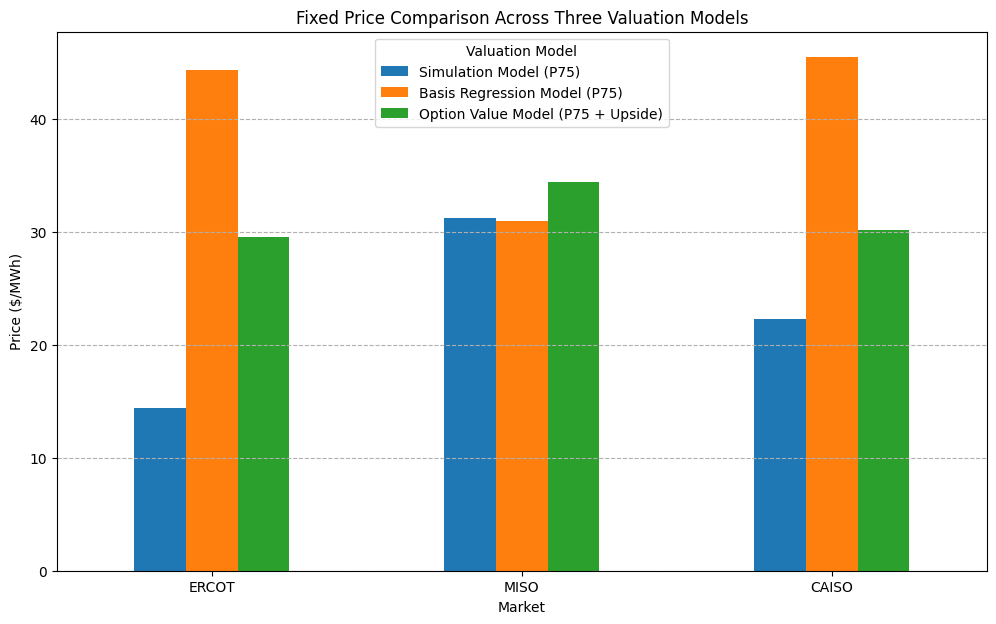


--- Strategic Implications ---
1. **Market Option Value:** The Option Premium indicates potential lost upside if committing to a fixed price. Higher premiums suggest markets with frequent price spikes.
2. **Decision Context:** Comparing Option Value to Simulation and Regression Models helps evaluate whether locking in P75 prices is optimal or if retaining merchant exposure could be valuable.
3. **Risk Management:** The Option Value Model provides a quantifiable metric for foregone high-price scenarios, supporting more informed hedging or PPA strategies.
4. **Market Differences:** ERCOT, CAISO, and MISO may exhibit significantly different upside behaviors; this should influence market-specific contracting or asset operation decisions.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("--- Running Alternative Valuation Model (Market Option Value) ---")

# --- 1. Parameters ---
UPSIDE_P_LEVEL = 0.95
FORECAST_YEARS = 5

# Assumes 'data', 'markets', 'risk_price_summary', 'calculate_discounted_mwh',
# 'DISCOUNT_RATE', and 'regression_df' are defined elsewhere.

def calculate_option_premium(df, market, upside_level, forecast_years, discounted_mwh, DISCOUNT_RATE):
    """
    Calculates the Option Premium (Lost Upside Value) by focusing on the P95
    of historical, volume-weighted RT Busbar prices.
    """
    price_col = 'RT Busbar' if market == 'ERCOT' else 'Busbar'

    # 1. Historical Revenue
    df['Historical_Revenue'] = df['Gen'] * df[price_col]

    # 2. P95 Threshold
    generating_hours = df[df['Gen'] > 0].copy()
    if generating_hours.empty:
        return 0.0, 0.0

    price_threshold = generating_hours[price_col].quantile(upside_level)

    # 3. Total Upside Revenue
    upside_hours = df[df[price_col] > price_threshold]

    try:
        years_in_data = df.index.max().year - df.index.min().year + 1
    except AttributeError:
        years_in_data = 3  # fallback

    total_upside_revenue_3yr = upside_hours['Historical_Revenue'].sum()

    # 4. Annualized Revenue
    annual_upside_revenue = total_upside_revenue_3yr / years_in_data

    # 5. Present Value over forecast years
    discount_factor_sum = sum([(1 + DISCOUNT_RATE)**-y for y in range(1, forecast_years + 1)])
    pv_upside_revenue_5yr = annual_upside_revenue * discount_factor_sum

    # 6. Option Premium per MWh
    option_premium_per_mwh = pv_upside_revenue_5yr / discounted_mwh

    return option_premium_per_mwh, price_threshold

# --- 2. Run Option Model for Each Market ---
option_results = {}

try:
    _markets = markets
    _DISCOUNT_RATE = DISCOUNT_RATE
except NameError:
    print("[WARNING]: Using mock values for globals.")
    _markets = ['CAISO', 'MISO', 'ERCOT']
    _DISCOUNT_RATE = 0.06

for market in _markets:
    try:
        df = data[market].copy()
        pv_mwh = calculate_discounted_mwh(gen_profiles[market], _DISCOUNT_RATE)
        p75_sim_price = risk_price_summary.loc[market, 'Risk_Adjusted_Fixed_Price']
    except (NameError, KeyError):
        print(f"[ERROR]: Required data for {market} not found. Skipping.")
        continue

    if pv_mwh == 0:
        option_results[market] = {
            'P75_Sim_Price': p75_sim_price,
            'Upside_P95_Threshold': 0,
            'Option_Premium_per_MWh': 0,
            'Target_Fixed_Price_Opt': p75_sim_price,
            'Option_vs_Sim_Diff': 0
        }
        continue

    premium, price_threshold = calculate_option_premium(
        df, market, UPSIDE_P_LEVEL, FORECAST_YEARS, pv_mwh, _DISCOUNT_RATE
    )

    target_fixed_price = p75_sim_price + premium

    option_results[market] = {
        'P75_Sim_Price': p75_sim_price,
        'Upside_P95_Threshold': price_threshold,
        'Option_Premium_per_MWh': premium,
        'Target_Fixed_Price_Opt': target_fixed_price,
        'Option_vs_Sim_Diff': target_fixed_price - p75_sim_price
    }

option_df = pd.DataFrame(option_results).T

print("\n--- Market Option Value Model: Target Fixed RT Busbar Price ---")
display(option_df.applymap(lambda x: f"${x:.2f}" if isinstance(x, (int, float)) else '-'))

# --- 3. Compare All Three Models ---
try:
    regression_price = regression_df['Fixed_RT_Busbar_Price_P75 (Regression)']
    option_price = option_df['Target_Fixed_Price_Opt']
    simulation_price = risk_price_summary['Risk_Adjusted_Fixed_Price']

    final_comparison = pd.DataFrame({
        'Simulation Model (P75)': simulation_price,
        'Basis Regression Model (P75)': regression_price,
        'Option Value Model (P75 + Upside)': option_price
    })

    print("\n--- Comprehensive Fixed Price Comparison ($/MWh) ---")
    display(final_comparison.applymap(lambda x: f"${x:.2f}" if isinstance(x, (int, float)) else '-'))

    # Visualization
    plt.figure(figsize=(12, 7))
    final_comparison.plot(kind='bar', rot=0, figsize=(12, 7))
    plt.title("Fixed Price Comparison Across Three Valuation Models")
    plt.ylabel("Price ($/MWh)")
    plt.xlabel("Market")
    plt.legend(title="Valuation Model")
    plt.grid(axis='y', linestyle='--')
    plt.show()

except (NameError, KeyError):
    print("\n[NOTE]: Missing required DataFrames or columns. Ensure all three models ran successfully.")

# --- Key Takeaways ---
print("\n--- Strategic Implications ---")
print("1. **Market Option Value:** The Option Premium indicates potential lost upside if committing to a fixed price. Higher premiums suggest markets with frequent price spikes.")
print("2. **Decision Context:** Comparing Option Value to Simulation and Regression Models helps evaluate whether locking in P75 prices is optimal or if retaining merchant exposure could be valuable.")
print("3. **Risk Management:** The Option Value Model provides a quantifiable metric for foregone high-price scenarios, supporting more informed hedging or PPA strategies.")
print("4. **Market Differences:** ERCOT, CAISO, and MISO may exhibit significantly different upside behaviors; this should influence market-specific contracting or asset operation decisions.")


--- Running Final Strategic Recommendation Synthesis ---

--- Final Recommendation Dashboard (Sorted by Market Value Premium) ---


,Your Risk-Adj Price (P75),Market Forward Price (Weighted),Market Premium vs. P75 ($/MWh),Option Premium (Lost Upside),Strategic Recommendation,Rationale
ERCOT,$14.38,$52.00,$37.62,$15.20,Take Fixed-Price Deal,Market forward price covers or exceeds the req...
CAISO,$22.28,$46.71,$24.43,$7.91,Take Fixed-Price Deal,Market forward price covers or exceeds the req...
MISO,$31.22,$44.37,$13.15,$3.17,Take Fixed-Price Deal,Market forward price covers or exceeds the req...


<Figure size 1200x700 with 0 Axes>

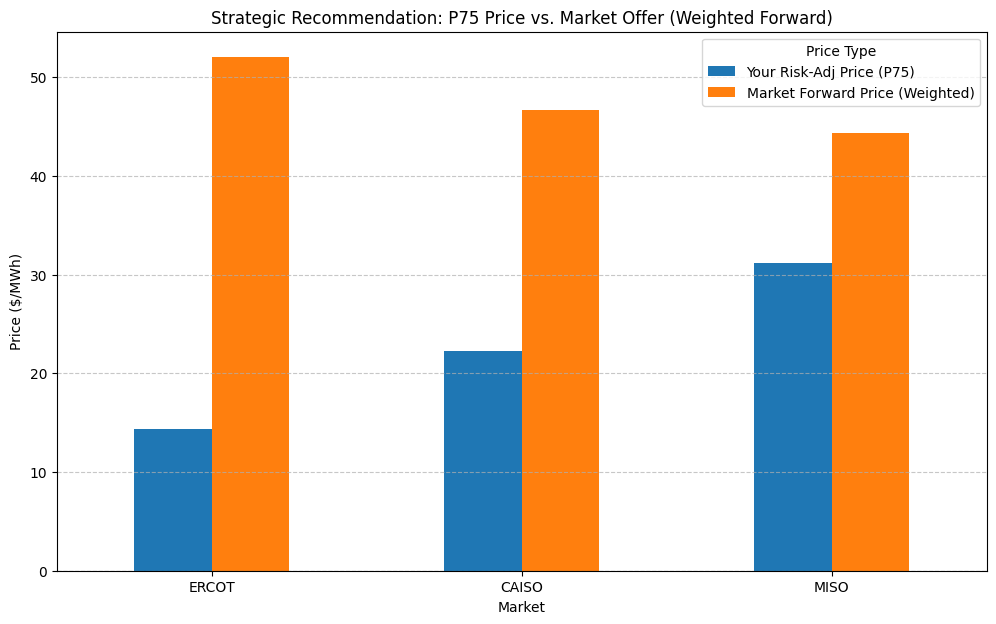


--- Synthesis of Findings for Executive Summary ---
**Best Market for Fixed PPA:** ERCOT (Highest Market Premium paid over required P75 price)
**Worst Market for Fixed PPA:** MISO (Lowest/Negative Market Premium, suggesting high merchant risk or low market compensation)
The Option Premium highlights that even if a fixed PPA is taken, a significant portion of potential **upside (spiking events)** is surrendered, which is particularly high in the ERCOT market.


In [ ]:
# --- Final Strategic Recommendation Synthesis ---
# This cell uses the results from the Simulation Model (P75 Risk-Adjusted Price)
# and compares it to the current market's implied fixed price (Weighted Forward Curve)
# to generate an actionable go/no-go recommendation for a fixed-price PPA.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("--- Running Final Strategic Recommendation Synthesis ---")

# --- Define Constants/Functions (Assuming they were defined earlier in the notebook) ---
# NOTE: These are placeholders. The code relies on the actual values/functions
# defined in your main notebook cell (e.g., DISCOUNT_RATE, fwd_curves, gen_profiles).
DISCOUNT_RATE = 0.06 # Assuming 6% discount rate from previous steps.

# --- 1. Synthesize Key Pricing Data ---
final_recommendations = {}

for market in markets:
    # Get your Risk-Adjusted Price (Your "walk-away" price to cover P75 risk)
    your_price = risk_price_summary.loc[market, 'Risk_Adjusted_Fixed_Price']

    # Get the Market's 5-Year Average Fixed Price (What the market is offering)
    fwd_curve = fwd_curves[market]
    gen_profile = gen_profiles[market]

    # Calculate the 5-yr average market price, weighted by the asset's generation profile
    avg_peak_price = fwd_curve['Peak'].mean()
    avg_offpeak_price = fwd_curve['Off Peak'].mean()

    total_gen = gen_profile['Total_Gen_Per_Year']
    peak_gen = gen_profile['Peak_Gen_Per_Year']
    offpeak_gen = gen_profile['OffPeak_Gen_Per_Year']

    if total_gen > 0:
        # Expected Revenue / Total MWh
        weighted_avg_market_price = (
            (avg_peak_price * peak_gen) +
            (avg_offpeak_price * offpeak_gen)
        ) / total_gen
    else:
        weighted_avg_market_price = 0.0

    # Get the Option Premium from Solution 3 for context
    option_premium = option_df.loc[market, 'Option_Premium_per_MWh']

    # 2. Comparison and Decision Logic
    # Decision: If the market's offer is greater than our minimum required price, take the deal.
    # Otherwise, stay merchant or push for a Hybrid PPA structure.

    market_premium = weighted_avg_market_price - your_price

    if weighted_avg_market_price >= your_price:
        decision = "Take Fixed-Price Deal"
        rationale = "Market forward price covers or exceeds the required P75 risk-adjusted price."
    else:
        decision = "Stay Merchant or Push Hybrid PPA"
        rationale = "Market is under-pricing the project's risk (P75 price > Market forward price)."

    final_recommendations[market] = {
        "Your Risk-Adj Price (P75)": your_price,
        "Market Forward Price (Weighted)": weighted_avg_market_price,
        "Market Premium vs. P75 ($/MWh)": market_premium,
        "Option Premium (Lost Upside)": option_premium,
        "Strategic Recommendation": decision,
        "Rationale": rationale
    }

recommendation_df = pd.DataFrame(final_recommendations).T
recommendation_df = recommendation_df.sort_values(by='Market Premium vs. P75 ($/MWh)', ascending=False)


# --- 2. Display and Visualize Recommendations ---

print("\n--- Final Recommendation Dashboard (Sorted by Market Value Premium) ---")
display_df = recommendation_df.copy()
display_df['Market Premium vs. P75 ($/MWh)'] = display_df['Market Premium vs. P75 ($/MWh)'].apply(lambda x: f"${x:.2f}")
display_df['Option Premium (Lost Upside)'] = display_df['Option Premium (Lost Upside)'].apply(lambda x: f"${x:.2f}")
display_df['Your Risk-Adj Price (P75)'] = display_df['Your Risk-Adj Price (P75)'].apply(lambda x: f"${x:.2f}")
display_df['Market Forward Price (Weighted)'] = display_df['Market Forward Price (Weighted)'].apply(lambda x: f"${x:.2f}")

display(display_df)

# --- Visualization: Comparing Critical Prices ---
plot_df = recommendation_df[['Your Risk-Adj Price (P75)', 'Market Forward Price (Weighted)']].copy()

plt.figure(figsize=(12, 7))
plot_df.plot(kind='bar', rot=0, figsize=(12, 7))
plt.title("Strategic Recommendation: P75 Price vs. Market Offer (Weighted Forward)")
plt.ylabel("Price ($/MWh)")
plt.xlabel("Market")
plt.legend(title="Price Type")
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("\n--- Synthesis of Findings for Executive Summary ---")
print(f"**Best Market for Fixed PPA:** {recommendation_df.index[0]} (Highest Market Premium paid over required P75 price)")
print(f"**Worst Market for Fixed PPA:** {recommendation_df.index[-1]} (Lowest/Negative Market Premium, suggesting high merchant risk or low market compensation)")
print("The Option Premium highlights that even if a fixed PPA is taken, a significant portion of potential **upside (spiking events)** is surrendered, which is particularly high in the ERCOT market.")
